In [ ]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=224eba971ed4d02d4a55887efe9f53a6247fd1ed82d9002d77afda0a003a141f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [ ]:
!unzip dataset_1000.zip

Archive:  dataset_1000.zip
 extracting: 000000.png              
 extracting: 000000_seg.png          
 extracting: 000000_ldmks.txt        
 extracting: 000001.png              
 extracting: 000001_seg.png          
 extracting: 000001_ldmks.txt        
 extracting: 000002.png              
 extracting: 000002_seg.png          
 extracting: 000002_ldmks.txt        
 extracting: 000003.png              
 extracting: 000003_seg.png          
 extracting: 000003_ldmks.txt        
 extracting: 000004.png              
 extracting: 000004_seg.png          
 extracting: 000004_ldmks.txt        
 extracting: 000005.png              
 extracting: 000005_seg.png          
 extracting: 000005_ldmks.txt        
 extracting: 000006.png              
 extracting: 000006_seg.png          
 extracting: 000006_ldmks.txt        
 extracting: 000007.png              
 extracting: 000007_seg.png          
 extracting: 000007_ldmks.txt        
 extracting: 000008.png              
 extracting: 000008_seg

**Imports**

In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import albumentations

**Config**

In [ ]:
#paths
ROOT_PATH = '../content'
OUTPUT_PATH = '../content/outputs'
# hyperparameters
BATCH_SIZE = 32 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True

**Utility**

In [ ]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    #plt.savefig(f"{OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()
  

**Dataset Class**

In [ ]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples             

def get_keypoints(file_name):
  #remove file extension from file_name
  idx = [idx for idx, x in enumerate(file_name) if x == '.']
  file_name = file_name[:idx[0]]
  #get name of keypoint file
  file_name = file_name + "_ldmks.txt"
  #fetch file and extract keypoints as list of tuples
  keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
  keypoints = np.array(keypoints, dtype='float32')
  return keypoints

class FaceKeypointDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
        #normalization required for pretrained pytorch networks
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}/{self.data[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))
        # again reshape to add grayscale channel format
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype=torch.float)
        image = self.normalize(image)
        # get the keypoints
        keypoints = get_keypoints(self.data[index])
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

**Setup Data**

Training sample instances: 900
Validation sample instances: 100


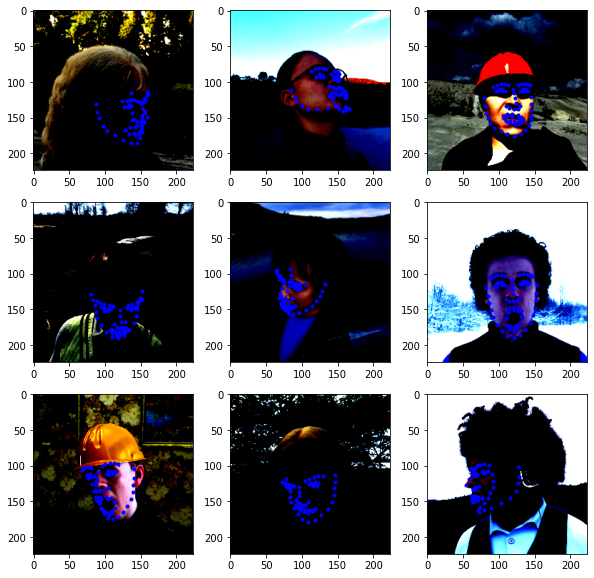

In [ ]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{ROOT_PATH}", TEST_SPLIT) #TODO add 'data' folder containing images and keypoints
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointDataset(training_samples, f"{ROOT_PATH}")
valid_data = FaceKeypointDataset(valid_samples, f"{ROOT_PATH}")
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    dataset_keypoints_plot(valid_data)


**Model Class**

In [ ]:
class FaceKeypointResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, 140)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

**Training (if not pretrained)**

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training intermediate layer parameters...
Epoch 1 of 30
Training


29it [00:26,  1.09it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:1
i:0


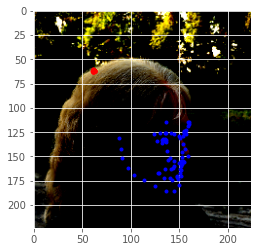

 67%|██████▋   | 2/3 [00:01<00:00,  1.69it/s]

epochs:1
i:1


4it [00:01,  2.28it/s]                       


epochs:1
i:2
epochs:1
i:3
Train Loss: 97.5910
Val Loss: 61.5211
Epoch 2 of 30
Training


29it [00:20,  1.45it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:2
i:0


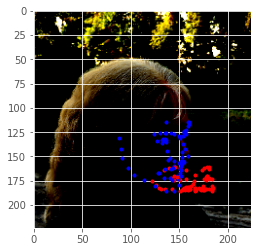

 67%|██████▋   | 2/3 [00:01<00:00,  1.70it/s]

epochs:2
i:1


4it [00:01,  2.29it/s]                       


epochs:2
i:2
epochs:2
i:3
Train Loss: 37.3538
Val Loss: 21.8611
Epoch 3 of 30
Training


29it [00:19,  1.52it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:3
i:0


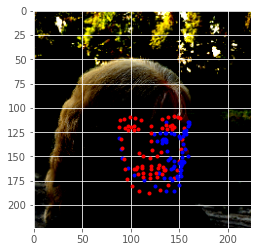

 67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]

epochs:3
i:1


4it [00:01,  2.25it/s]                       


epochs:3
i:2
epochs:3
i:3
Train Loss: 12.9205
Val Loss: 13.6230
Epoch 4 of 30
Training


29it [00:18,  1.54it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:4
i:0


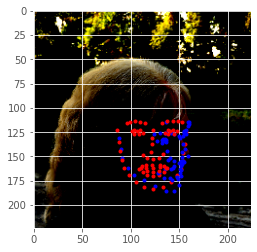

 67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]

epochs:4
i:1


4it [00:01,  2.23it/s]                       


epochs:4
i:2
epochs:4
i:3
Train Loss: 11.9588
Val Loss: 12.6900
Epoch 5 of 30
Training


29it [00:18,  1.54it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:5
i:0


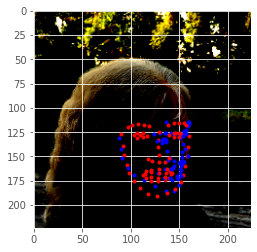

 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

epochs:5
i:1


4it [00:01,  2.23it/s]                       


epochs:5
i:2
epochs:5
i:3
Train Loss: 11.7022
Val Loss: 12.0580
Epoch 6 of 30
Training


29it [00:19,  1.51it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:6
i:0


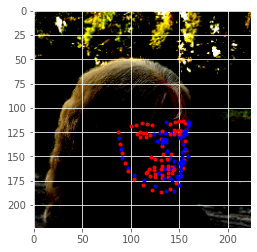

 67%|██████▋   | 2/3 [00:01<00:00,  1.51it/s]

epochs:6
i:1


4it [00:01,  2.07it/s]                       


epochs:6
i:2
epochs:6
i:3
Train Loss: 10.8205
Val Loss: 9.9556
Epoch 7 of 30
Training


29it [00:18,  1.53it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:7
i:0


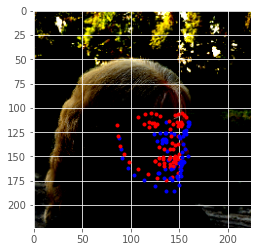

 67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]

epochs:7
i:1


4it [00:01,  2.22it/s]                       


epochs:7
i:2
epochs:7
i:3
Train Loss: 8.1462
Val Loss: 9.3000
Epoch 8 of 30
Training


29it [00:18,  1.53it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:8
i:0


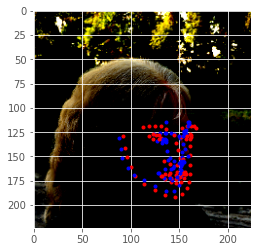

 67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]

epochs:8
i:1


4it [00:01,  2.20it/s]                       


epochs:8
i:2
epochs:8
i:3
Train Loss: 6.7776
Val Loss: 8.3364
Epoch 9 of 30
Training


29it [00:19,  1.48it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:9
i:0


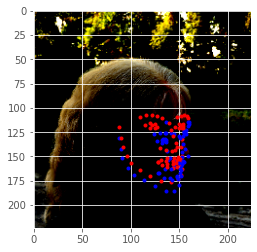

 67%|██████▋   | 2/3 [00:01<00:00,  1.61it/s]

epochs:9
i:1


4it [00:01,  2.16it/s]                       


epochs:9
i:2
epochs:9
i:3
Train Loss: 6.4108
Val Loss: 7.4486
Epoch 10 of 30
Training


29it [00:19,  1.52it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:10
i:0


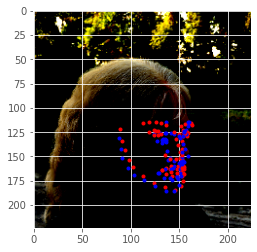

 67%|██████▋   | 2/3 [00:01<00:00,  1.66it/s]

epochs:10
i:1


4it [00:01,  2.24it/s]                       


epochs:10
i:2
epochs:10
i:3
Train Loss: 5.6237
Val Loss: 5.1498
Epoch 11 of 30
Training


29it [00:19,  1.52it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:11
i:0


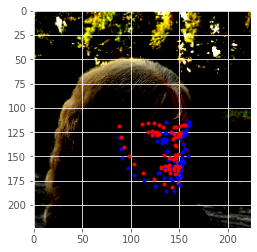

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

epochs:11
i:1


4it [00:01,  2.20it/s]                       


epochs:11
i:2
epochs:11
i:3
Train Loss: 5.5433
Val Loss: 5.7707
Epoch 12 of 30
Training


29it [00:19,  1.47it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:12
i:0


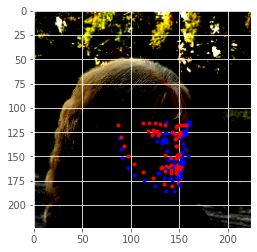

 67%|██████▋   | 2/3 [00:01<00:00,  1.59it/s]

epochs:12
i:1


4it [00:01,  2.16it/s]                       


epochs:12
i:2
epochs:12
i:3
Train Loss: 5.2138
Val Loss: 4.8261
Epoch 13 of 30
Training


29it [00:18,  1.53it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:13
i:0


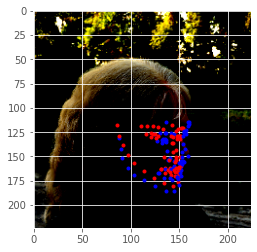

 67%|██████▋   | 2/3 [00:01<00:00,  1.62it/s]

epochs:13
i:1


4it [00:01,  2.20it/s]                       


epochs:13
i:2
epochs:13
i:3
Train Loss: 4.7309
Val Loss: 5.5124
Epoch 14 of 30
Training


29it [00:18,  1.53it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:14
i:0


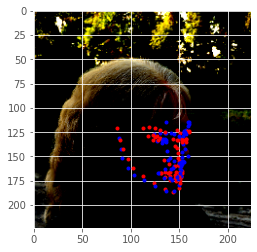

 67%|██████▋   | 2/3 [00:01<00:00,  1.67it/s]

epochs:14
i:1


4it [00:01,  2.22it/s]                       


epochs:14
i:2
epochs:14
i:3
Train Loss: 4.7342
Val Loss: 5.1471
Epoch 15 of 30
Training


29it [00:19,  1.49it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:15
i:0


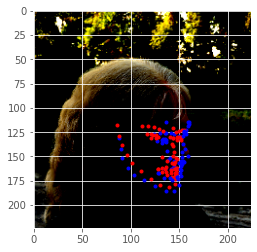

 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

epochs:15
i:1


4it [00:01,  2.22it/s]                       


epochs:15
i:2
epochs:15
i:3
Train Loss: 4.5252
Val Loss: 3.9840
Epoch 16 of 30
Training


29it [00:18,  1.54it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:16
i:0


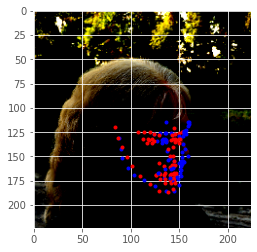

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

epochs:16
i:1


4it [00:01,  2.21it/s]                       


epochs:16
i:2
epochs:16
i:3
Train Loss: 4.3670
Val Loss: 4.7549
Epoch 17 of 30
Training


29it [00:18,  1.53it/s]                        


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:17
i:0


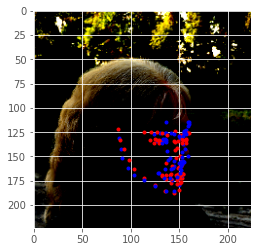

 67%|██████▋   | 2/3 [00:01<00:00,  1.49it/s]

epochs:17
i:1


4it [00:01,  2.04it/s]                       


epochs:17
i:2
epochs:17
i:3
Train Loss: 4.0313
Val Loss: 4.4458
Epoch 18 of 30
Training


29it [00:19,  1.50it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:18
i:0


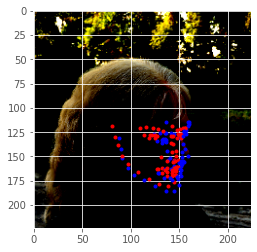

 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

epochs:18
i:1


4it [00:01,  2.20it/s]                       


epochs:18
i:2
epochs:18
i:3
Train Loss: 4.2986
Val Loss: 4.0784
Epoch 19 of 30
Training


29it [00:18,  1.54it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:19
i:0


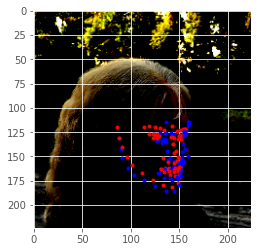

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

epochs:19
i:1


4it [00:01,  2.19it/s]                       


epochs:19
i:2
epochs:19
i:3
Train Loss: 4.2714
Val Loss: 4.0092
Epoch 20 of 30
Training


29it [00:18,  1.53it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:20
i:0


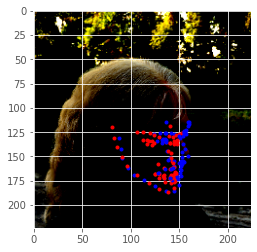

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

epochs:20
i:1


4it [00:01,  2.19it/s]                       


epochs:20
i:2
epochs:20
i:3
Train Loss: 4.1457
Val Loss: 5.3223
Epoch 21 of 30
Training


29it [00:19,  1.49it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:21
i:0


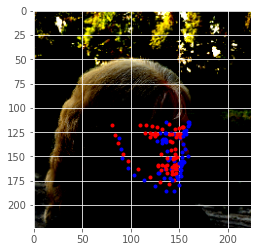

 67%|██████▋   | 2/3 [00:01<00:00,  1.60it/s]

epochs:21
i:1


4it [00:01,  2.18it/s]                       


epochs:21
i:2
epochs:21
i:3
Train Loss: 4.1681
Val Loss: 4.8238
Epoch 22 of 30
Training


29it [00:18,  1.53it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:22
i:0


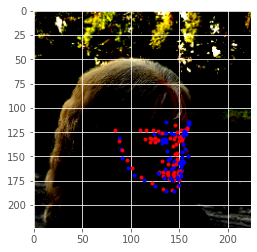

 67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]

epochs:22
i:1


4it [00:01,  2.18it/s]                       


epochs:22
i:2
epochs:22
i:3
Train Loss: 3.9784
Val Loss: 4.1227
Epoch 23 of 30
Training


29it [00:19,  1.51it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:23
i:0


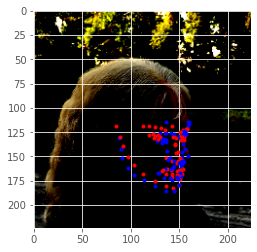

 67%|██████▋   | 2/3 [00:01<00:00,  1.61it/s]

epochs:23
i:1


4it [00:01,  2.17it/s]                       


epochs:23
i:2
epochs:23
i:3
Train Loss: 3.9832
Val Loss: 3.6372
Epoch 24 of 30
Training


29it [00:19,  1.48it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:24
i:0


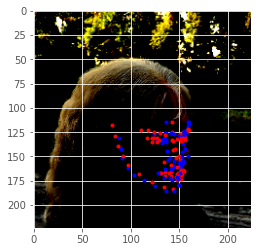

 67%|██████▋   | 2/3 [00:01<00:00,  1.36it/s]

epochs:24
i:1


4it [00:02,  1.94it/s]                       


epochs:24
i:2
epochs:24
i:3
Train Loss: 3.9482
Val Loss: 3.7809
Epoch 25 of 30
Training


29it [00:18,  1.53it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:25
i:0


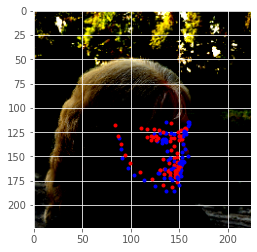

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

epochs:25
i:1


4it [00:01,  2.20it/s]                       


epochs:25
i:2
epochs:25
i:3
Train Loss: 3.9492
Val Loss: 4.0384
Epoch 26 of 30
Training


29it [00:18,  1.53it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:26
i:0


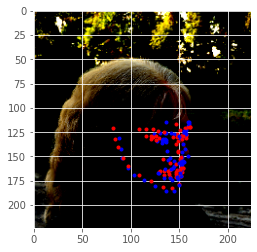

 67%|██████▋   | 2/3 [00:01<00:00,  1.64it/s]

epochs:26
i:1


4it [00:01,  2.19it/s]                       


epochs:26
i:2
epochs:26
i:3
Train Loss: 3.6742
Val Loss: 3.3766
Epoch 27 of 30
Training


29it [00:19,  1.49it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:27
i:0


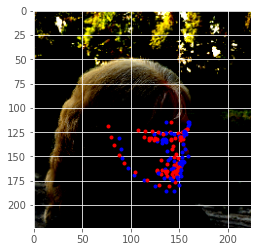

 67%|██████▋   | 2/3 [00:01<00:00,  1.60it/s]

epochs:27
i:1


4it [00:01,  2.14it/s]                       


epochs:27
i:2
epochs:27
i:3
Train Loss: 3.4634
Val Loss: 3.5438
Epoch 28 of 30
Training


29it [00:19,  1.53it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:28
i:0


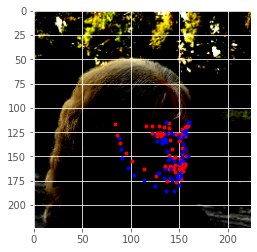

 67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]

epochs:28
i:1


4it [00:01,  2.06it/s]                       


epochs:28
i:2
epochs:28
i:3
Train Loss: 3.5620
Val Loss: 4.3182
Epoch 29 of 30
Training


29it [00:19,  1.53it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:29
i:0


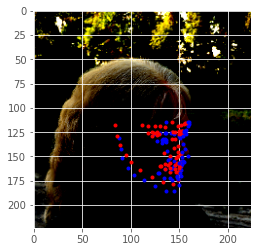

 67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

epochs:29
i:1


4it [00:01,  2.17it/s]                       


epochs:29
i:2
epochs:29
i:3
Train Loss: 3.8245
Val Loss: 4.6580
Epoch 30 of 30
Training


29it [00:19,  1.48it/s]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:0


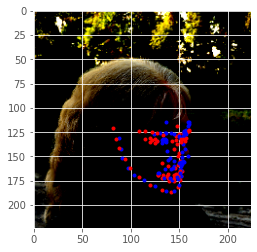

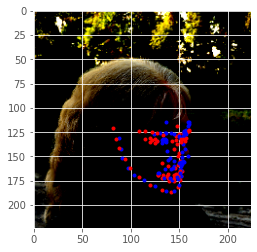

 33%|███▎      | 1/3 [00:01<00:02,  1.17s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:1


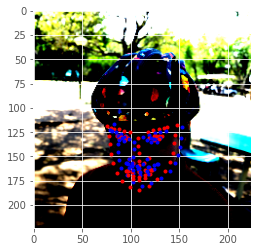

 67%|██████▋   | 2/3 [00:01<00:00,  1.03it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:2


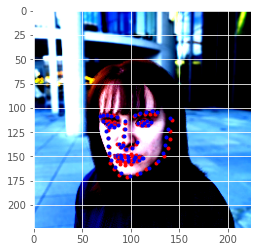

100%|██████████| 3/3 [00:02<00:00,  1.10it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:3


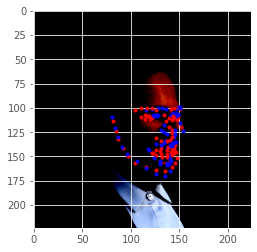

4it [00:03,  1.18it/s]

Train Loss: 3.6386
Val Loss: 3.6454


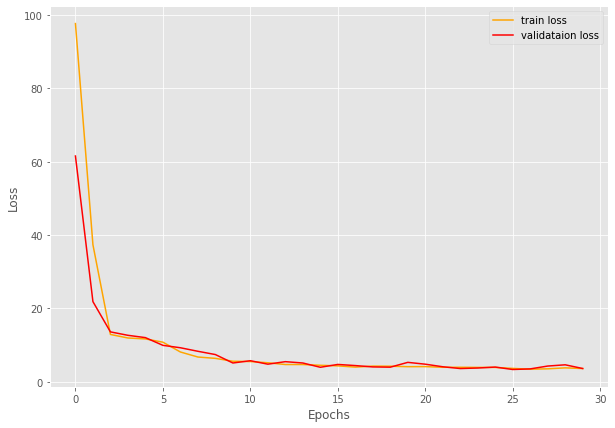

DONE TRAINING


In [ ]:
matplotlib.style.use('ggplot')
#model 
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointResNet50(pretrained=True, requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss() #TODO test MSELoss

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss, 

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            acc = np.square(outputs - keypoints).mean() #TODO not sure if this is a good accuracy measure as it seems more like a loss measure
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            print('epochs:'+str(epoch+1))
            print('i:'+str(i))
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss, acc

# Do training and validation

# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
acc = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, acc_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    acc.append(acc_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'Accuracy:{acc_val:.4f}')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(acc, color='blue', label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"{OUTPUT_PATH}/loss.png")
plt.show()
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'sample_data/my_model_1000.pt')
print('DONE TRAINING')


**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training 

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [ ]:
#Imports required for running video locally:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import transforms
import pretrainedmodels

In [ ]:
model = FaceKeypointResNet50(pretrained=False, requires_grad=False).to(DEVICE)
checkpoint = torch.load('sample_data/my_model_1000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#capture the webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if cap.isOpened()==False:
  print('Error while trying to open webcam. Please check again...')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# set up the save file path
save_path = "sample_data/vid_keypoint_detection.mp4"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{save_path}", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        with torch.no_grad():
            image = frame
            image = cv2.resize(image, (224, 224))
            orig_frame = image.copy()
            orig_h, orig_w, c = orig_frame.shape
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
            image = norm(image)
            image = image.unsqueeze(0).to(DEVICE)
            outputs = model(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        keypoints = outputs
        for p in range(keypoints.shape[0]):
            cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                        1, (0, 0, 255), -1, cv2.LINE_AA)
        orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
        cv2.imshow('Facial Keypoint Frame', orig_frame)
        out.write(orig_frame)
        # press `q` to exit
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break
 
    else: 
        break

Freezing intermediate layer parameters...
Error while trying to open webcam. Please check again...
